<a href="https://colab.research.google.com/github/baroodb/code/blob/main/siamese_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import imutils
import os
from imutils import paths
import numpy as np
import cv2
import matplotlib.pyplot as plt
 

CLASSES = {'angela': 0, 'giacomo': 1, 'obama': 2, 'red': 3}

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
PROJECT = 'my-third-project-326309'
LOCATION = 'gs://baroo_bucket'
TRAIN = 'dataset2/train'
VAL = 'dataset2/valid'

In [ ]:
!gcloud config set project $PROJECT

Updated property [core/project].


In [ ]:
#!gsutil mb -l asia $LOCATION

In [ ]:
!gsutil ls $LOCATION/dataset2

gs://baroo_bucket/dataset2/train/
gs://baroo_bucket/dataset2/valid/


In [ ]:
!gsutil -m cp -r gs://baroo_bucket/dataset2 ./

In [ ]:
shutil.rmtree('dataset')

In [ ]:
first_three = []
max_rows = 5
for folder in os.listdir(TRAIN):
  i = 0 
  for element in os.listdir(os.path.join(TRAIN, folder)):
    
    print(element)
    i += 1

    if i == max_rows:
      break
    
  print('--------------------')


In [ ]:
len(list(paths.list_images(VAL)))

In [ ]:
class Config:

  BATCH_SIZE = 2
  EPOCHS = 100
  IMG_SHAPE = (224, 224, 3)

  MODEL_PATH = 'model/saved_model'
  PLOT_PATH = 'plots/plots.png'


In [ ]:
def _get_label(path):
  label = path.split(os.path.sep)[-2]
  return label

def make_dataset(path):
  images, labels = [], []
  filenames = list(paths.list_images(path))

  for filename in filenames:
    label = _get_label(filename)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224)).astype('float32') / 255.0

    images.append(img)
    labels.append(CLASSES[label])

  images = np.array(images)
  labels = np.array(labels)

  return images, labels


In [ ]:
train_images, train_labels = make_dataset(TRAIN)
val_images, val_labels = make_dataset(VAL)

In [ ]:
#shuffling training

shuffler_train = np.random.permutation(len(train_images))

train_img_shuffled = train_images[shuffler_train]
train_lb_suffled = train_labels[shuffler_train]

#shuffling val 

shuffler_val = np.random.permutation(len(val_images))

val_img_shuffled = val_images[shuffler_val]
val_lb_suffled = val_labels[shuffler_val]

In [ ]:
train_lb_suffled

array([1, 1, 2, 2, 0, 3, 2, 0, 3, 2, 2, 1, 3, 3, 0, 0, 1, 3, 1, 1, 2, 1,
       0, 3, 3, 0, 3, 0, 2])

In [ ]:
val_lb_suffled

array([1, 2, 0, 1, 2, 0, 1, 0, 2, 3, 3, 3])

In [ ]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(29, 224, 224, 3) (29,)
(12, 224, 224, 3) (12,)


In [ ]:
def make_pairs(images, labels):
  grouped = [np.where(labels == i)[0] for i in range(4)]

  pos_pairs = []
  pos_labels = []


  for i in range(len(images)):

    cur_image = images[i]
    cur_label = labels[i]

    row_label = grouped[cur_label]
    pos_pair = images[np.random.choice(row_label)]

    pos_pairs.append([cur_image, pos_pair])
    pos_labels.append([1])

    #
    neg_grouped = np.where(labels != cur_label)[0]
    neg_id = np.random.choice(neg_grouped)
    neg_pair = images[neg_id]

    pos_pairs.append([cur_image, neg_pair])
    pos_labels.append([0])
  
  pos_pairs = np.array(pos_pairs)
  pos_labels = np.array(pos_labels)

  return pos_pairs, pos_labels


In [ ]:
pairs, labels = make_pairs(train_img_shuffled, train_lb_suffled)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


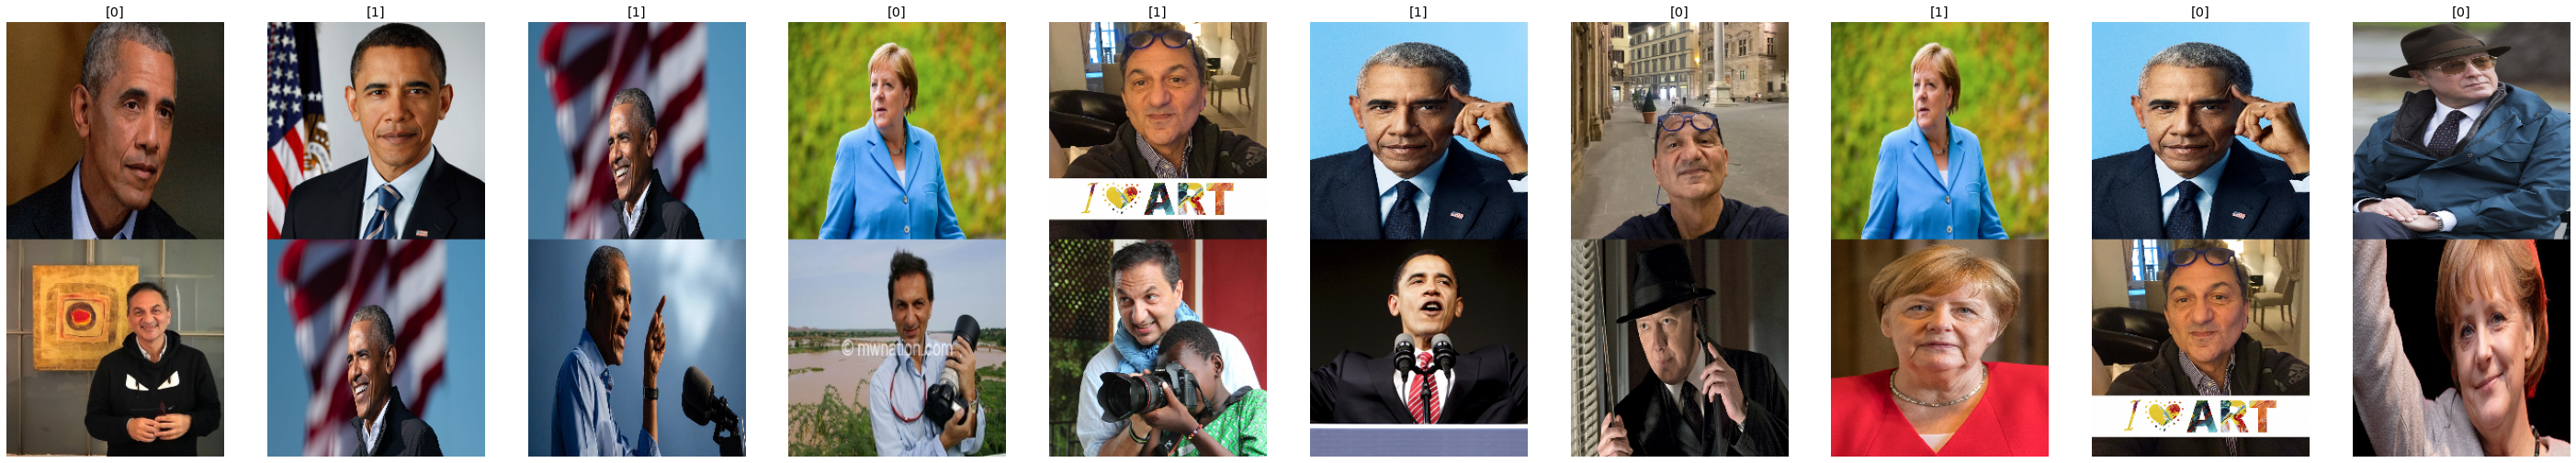

In [ ]:
plt.figure(figsize=(50, 70))
picked = np.random.choice(list(range(len(pairs))), size=(10,))

for i in range(len(picked)):
  plt.subplot(1, 10, i+1)
  plt.imshow(np.vstack([pairs[picked[i]][0], pairs[picked[i]][1]]))
  plt.title(labels[picked[i]])
  plt.axis('OFF')


In [ ]:
#lets build our model 

# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os

def build_feature_extractor(inputShape, embeddingDim=64):
  
  inputs = Input(inputShape)
  
  x = Conv2D(64, (2, 2), activation='relu')(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  x = Conv2D(64, (2, 2), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  return Model(inputs=inputs, outputs=outputs)

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)


In [ ]:
# Building the siamese architecture
config = Config()

imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(config.IMG_SHAPE)

feature_extractor = build_feature_extractor(config.IMG_SHAPE)

featuresA = feature_extractor(imgA)
featuresB = feature_extractor(imgB)

dim_output = Lambda(euclidean_distance)([featuresA, featuresB])

output = Dense(units=1, activation='sigmoid')(dim_output)

siamese = Model(inputs=[imgA, imgB], outputs=output)

print('INFO: Compiling the model...')
siamese.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO: Compiling the model...


In [ ]:
siamese.summary()

In [ ]:
# data for training 
train_pairs, train_pairs_labels = make_pairs(train_img_shuffled, train_lb_suffled)
val_pairs, val_pairs_labels = make_pairs(val_img_shuffled, val_lb_suffled)

train_pairs_labels

In [ ]:
import tensorflow as tf

checkpoint_filepath = 'checkpoints/best.ckpt'

cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
H = siamese.fit(x=[train_pairs[:, 0], train_pairs[:, 1]], 
            y=train_pairs_labels[:], 
            validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_pairs_labels[:]), 
            batch_size=config.BATCH_SIZE, 
            epochs=config.EPOCHS, callbacks=[cb])

plot_training(H, 'plots/plot.png')

In [ ]:
siamese.evaluate(x=[val_pairs[:, 0], val_pairs[:, 1]], y=val_pairs_labels[:])

1/1 [==============================] - 0s 91ms/step - loss: 0.5471 - accuracy: 0.9583


[0.5470911860466003, 0.9583333134651184]

In [ ]:
siamese.load_weights(checkpoint_filepath)